                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-01-11  2013-01-11
End Period                 2022-12-30  2022-12-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          103.71%     -21.86%
CAGR﹪                     7.4%        -2.44%

Sharpe                     0.92        -0.27
Prob. Sharpe Ratio         99.85%      19.66%
Smart Sharpe               0.92        -0.26
Sortino                    1.38        -0.37
Smart Sortino              1.37        -0.37
Sortino/√2                 0.97        -0.26
Smart Sortino/√2           0.97        -0.26
Omega                      1.17        1.17

Max Drawdown               -11.35%     -32.99%
Longest DD Days            632         3208
Volatility (ann.)          7.82%       7.83%
R^2                        0.01        0.01
Information Ratio          0.06        0.06
Calmar                     0.65

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-12-07,2016-02-26,2017-06-01,542,-11.353405,-10.821035
2,2021-03-02,2022-01-31,2022-06-02,457,-8.835500,-7.938081
3,2013-02-25,2013-10-16,2014-03-03,371,-7.665829,-7.403102
4,2017-07-25,2018-05-28,2019-04-18,632,-7.309265,-6.533739
5,2020-05-06,2020-08-28,2020-11-06,184,-6.194934,-5.935228


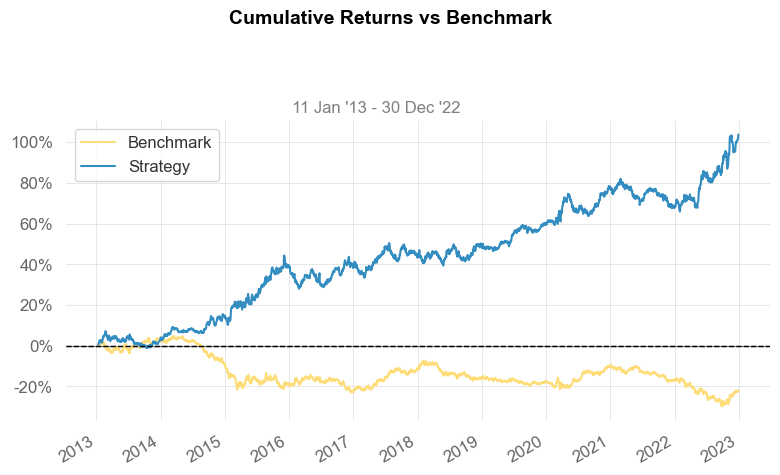

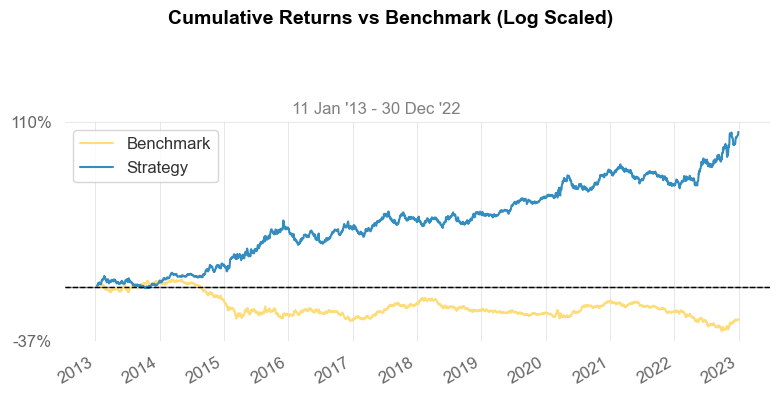

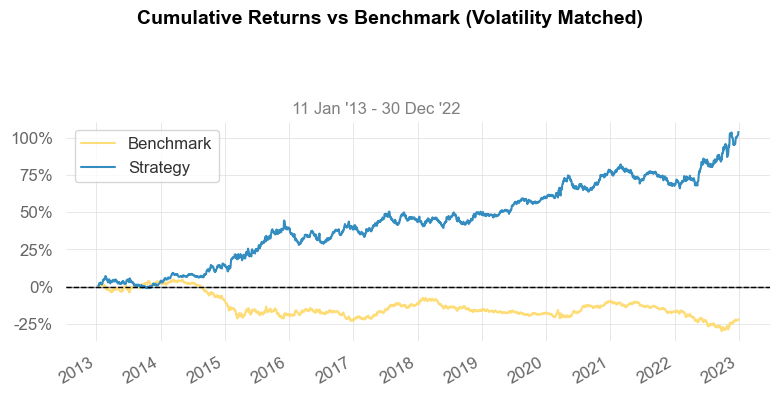

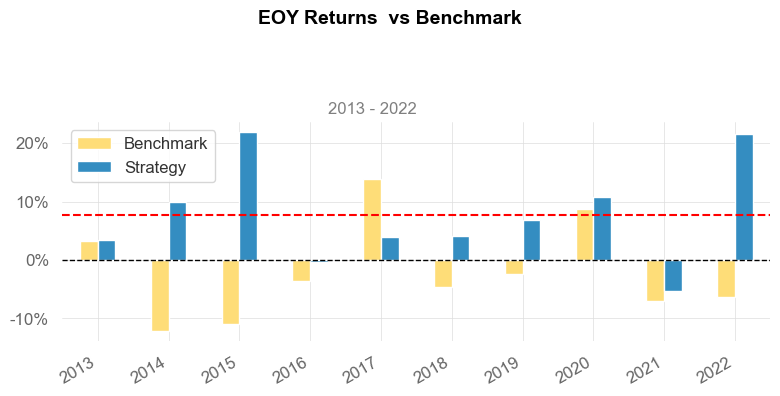

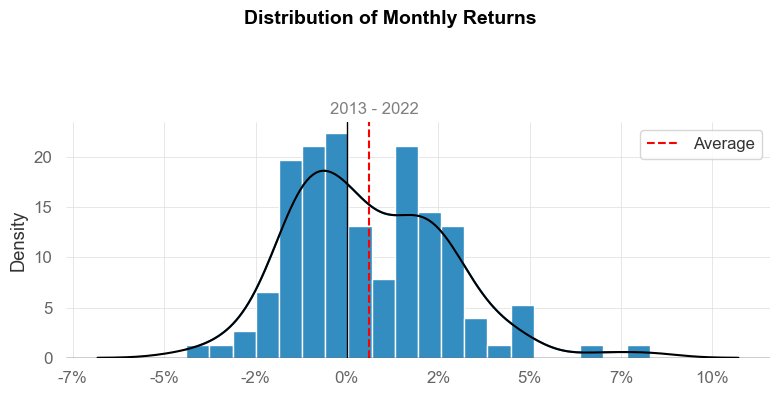

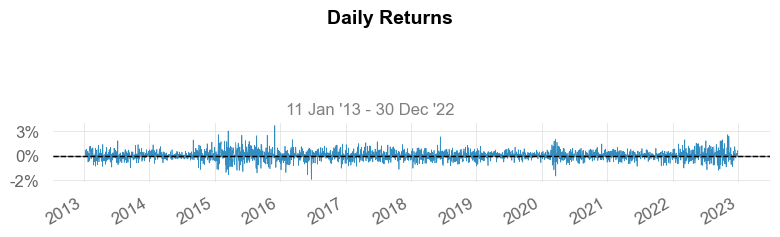

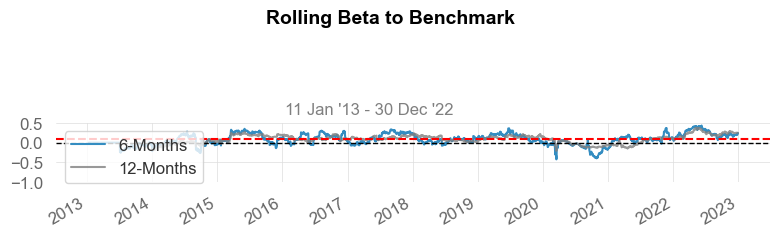

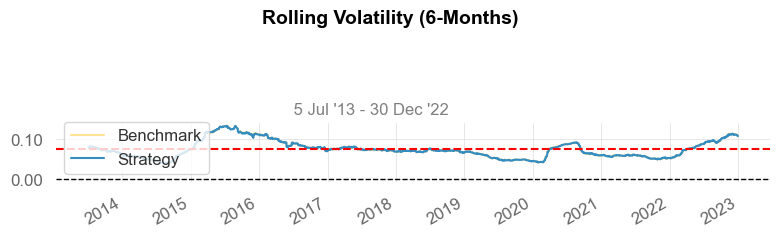

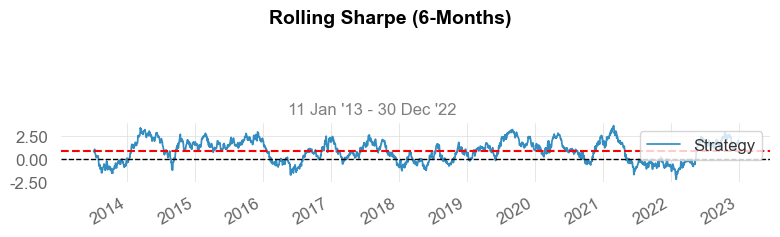

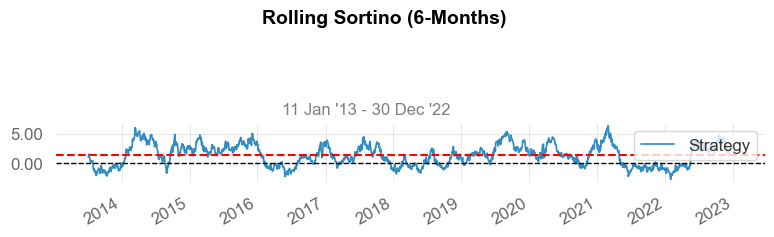

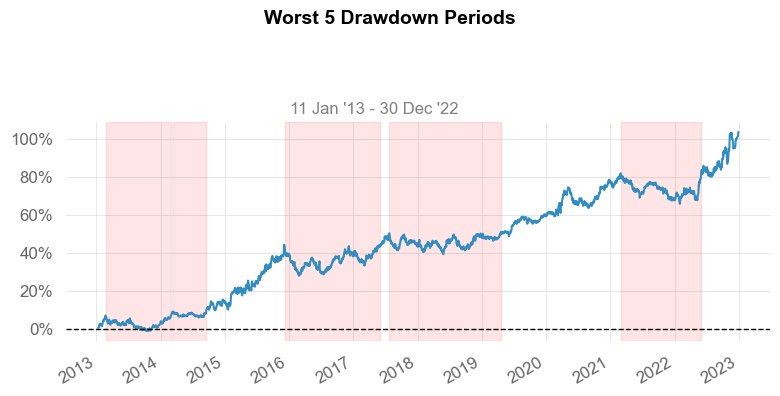

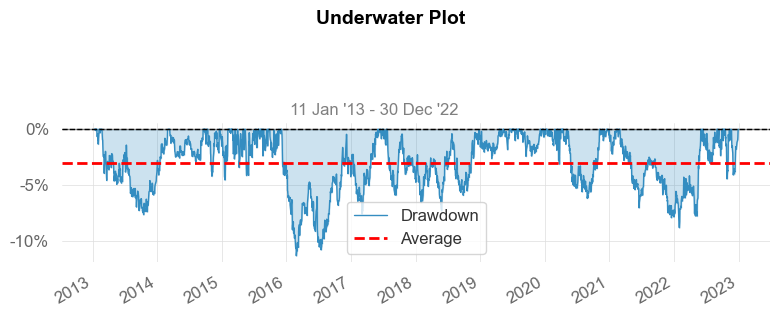

C:\Users\neham\anaconda3\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


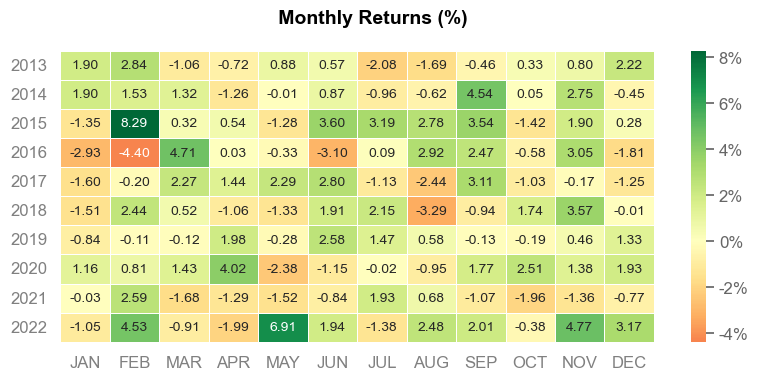

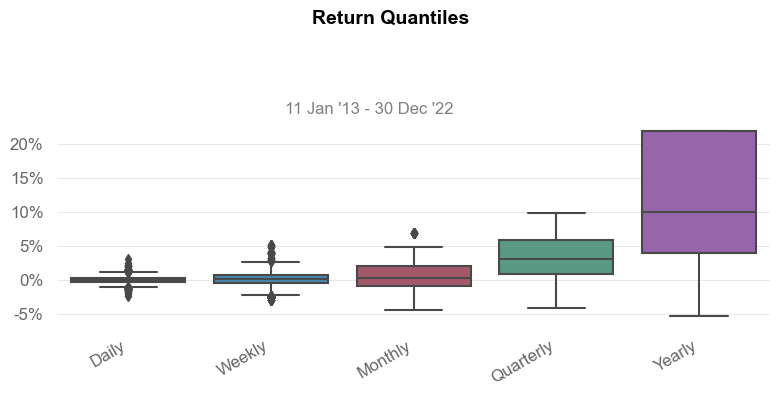

r    0.806542
s    2.102460
dtype: float64


In [1]:
import pandas as pd #necessary imports
import numpy as np
import quantstats as qs

class FinancialData:
    url = 'https://certificate.tpq.io/findata.csv' 
    
    def __init__(self,symbol):
        self.symbol = symbol
        self.retrieve_data()
        self.prepare_data()
        
    def retrieve_data(self): #retreiving data
        self.raw = pd.read_csv(self.url, index_col=0, parse_dates=True)
        
    def prepare_data(self): #calculating daily returns
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data['r'] = np.log(self.data/self.data.shift(1))
        
    def plot_data(self, cols=None):
        if cols is None:
            cols = [self.symbol]
        self.data[cols].plot(title=self.symbol)  

class OLSBacktester(FinancialData): #calculating lags
    def prepare_lags(self):
        self.cols = list()
        for lag in range(1, self.lags + 1):
            col = f'lag_{lag}'
            self.data[col] = self.data['r'].shift(lag)
            self.cols.append(col)
        self.data.dropna(inplace=True)   
        
    def backtest_strategy(self, lags=5): #calculating estimated sign of next day movement and strategy returns
        self.lags = lags
        self.prepare_lags()
        reg = np.linalg.lstsq(self.data[self.cols], self.data['r'], rcond=-1)[0]
        self.data['e'] = np.dot(self.data[self.cols], reg)
        self.data['p'] = np.sign(self.data['e'])
        self.data['s'] = self.data['p'] * self.data['r']
        strategy_returns = self.data[['r', 's']].sum().apply(np.exp)
        
        # Generating a full tear sheet
        qs.reports.full(self.data['s'], benchmark=self.data['r'])
        
        return strategy_returns

# Printing results
ols = OLSBacktester('EUR=')
strategy_returns = ols.backtest_strategy(lags=7)
print(strategy_returns)
